Cassie Richter - Group members: Abhi and Caleb

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics

import warnings                               
warnings.filterwarnings('ignore')

Let’s look at a time series of the log daily page views for the Wikipedia page for Peyton Manning. Split the data into history (all the data before 2015-12-31), and leave the rest as the test data in the black box. Do not use the test datat for your model fitting or selection process.

1. Design a 3-fold cross validation on the history data to select a model from ARIMA family.
2. Fit the selected model with all the history data, and forecast the length of the test set. 
3. Calculate the test rmse and plot the test data with the forecast. 

In [3]:
manning = pd.read_csv("/Users/cassierichter/Downloads/example_wp_log_peyton_manning.csv")
manning.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [4]:
history = manning[manning['ds'] < '2015-12-31']
history.tail()

,ds,y
2879,2015-12-26,7.120444
2880,2015-12-27,8.878776
2881,2015-12-28,9.250618
2882,2015-12-29,9.247925
2883,2015-12-30,8.391403


In [5]:
test = manning[manning['ds'] >= '2015-12-31']

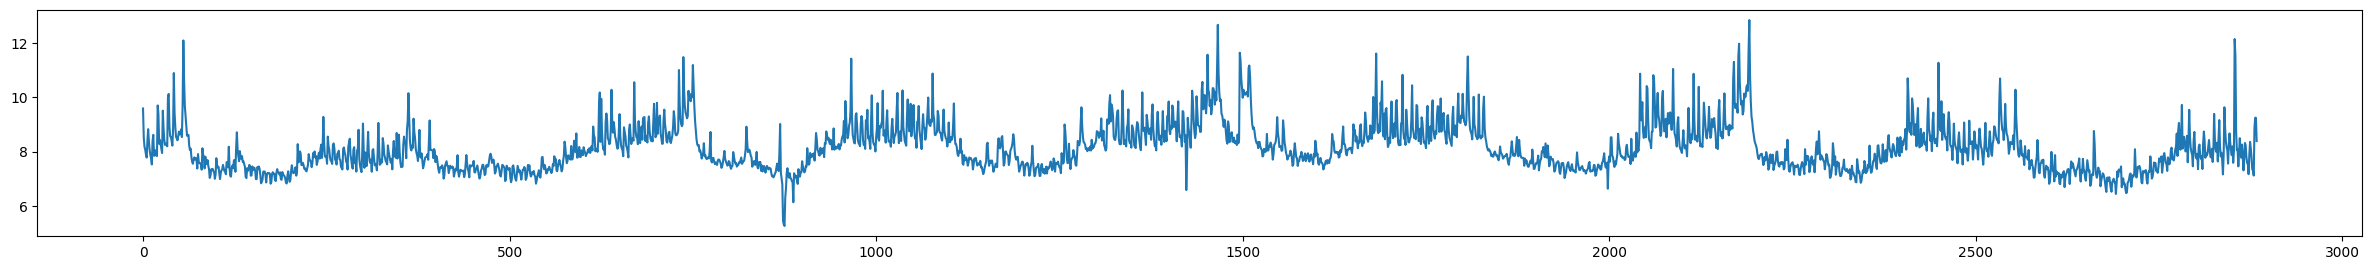

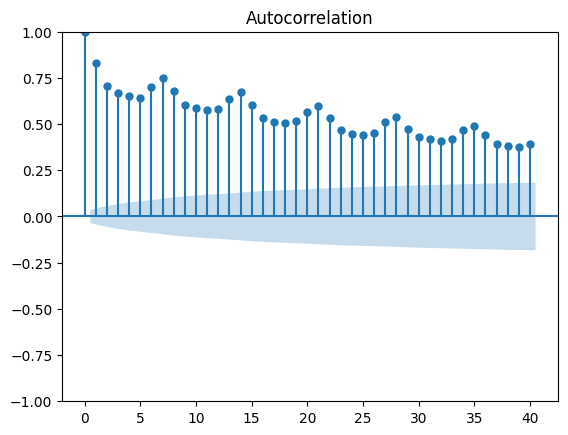

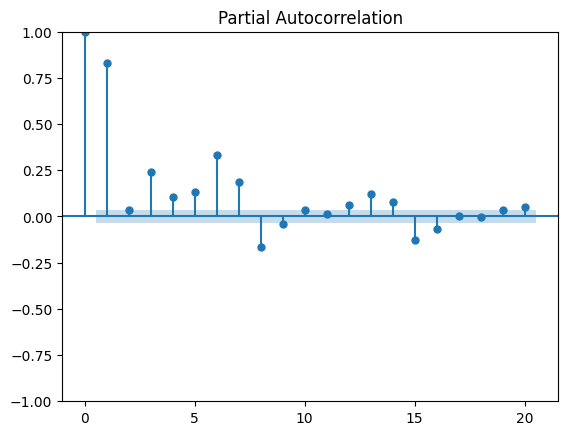

In [19]:
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)

plt.plot(history.y)
plt.show()

plot_acf(history.y,lags=40)
plt.show()

plot_pacf(history.y,lags=20)
plt.show()

In [ ]:
def plotMovingAverage(series, window, plot_actual=False, scale=1.96):

    rolling_mean = series.rolling(window=window,center=True).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    if plot_actual:
        plt.plot(series[window:], label="Actual values", color='#878a88', alpha=0.5)
        
    plt.legend(loc="upper left") 
    plt.grid(True)

In [ ]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
adf_test(history.y)

In [ ]:
plotMovingAverage(y, 30)

In [20]:
def evaluate_models_cv(dataset, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    K=3
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size=90
                            train_size=len(dataset)-validation_size*K
                            rmse=0
                            for k in range(0,3):
                                train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                model = ARIMA(train, order=trend_order, seasonal_order=seasonal_order) #each step: rolling one step forward to update the train se
                                model_fit = model.fit()
                                predictions=model_fit.forecast(validation_size)
                                rmse = rmse+np.sqrt(skmetrics.mean_squared_error(test, predictions))
                            rmse_avg=rmse/3
                            result.append((cfg, rmse_avg))
                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('ARIMA%s RMSE=%.3f' % (cfg,rmse_avg))
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_rmse))

In [21]:
p=[0,1,2]
d=[1,2]
q=[0,1,2]
P=[0,1,2]
D=[1]
Q=[0,1,2]
m=7

evaluate_models_cv(history.y, p,d,q,P,D,Q,m)

ARIMA[(0, 1, 0), (0, 1, 0, 7)] RMSE=2.272
ARIMA[(0, 1, 0), (0, 1, 1, 7)] RMSE=1.224
ARIMA[(0, 1, 0), (0, 1, 2, 7)] RMSE=1.209
ARIMA[(0, 1, 0), (1, 1, 1, 7)] RMSE=1.204
ARIMA[(0, 1, 0), (1, 1, 2, 7)] RMSE=0.937
ARIMA[(0, 2, 1), (2, 1, 1, 7)] RMSE=0.813
ARIMA[(1, 1, 1), (0, 1, 0, 7)] RMSE=0.784
ARIMA[(1, 1, 1), (1, 1, 0, 7)] RMSE=0.746
ARIMA[(1, 1, 1), (2, 1, 0, 7)] RMSE=0.733
Best SARIMA[(1, 1, 1), (2, 1, 0, 7)] RMSE=0.733


In [16]:
def diff(data, interval):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

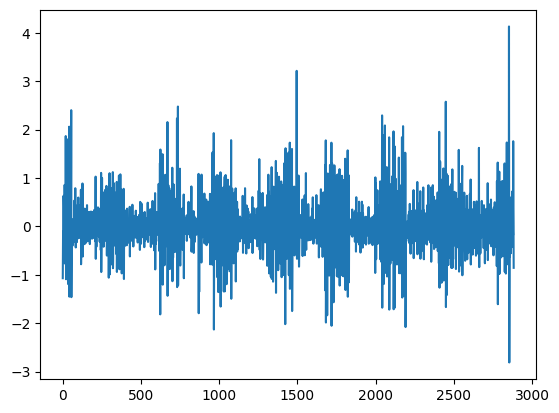

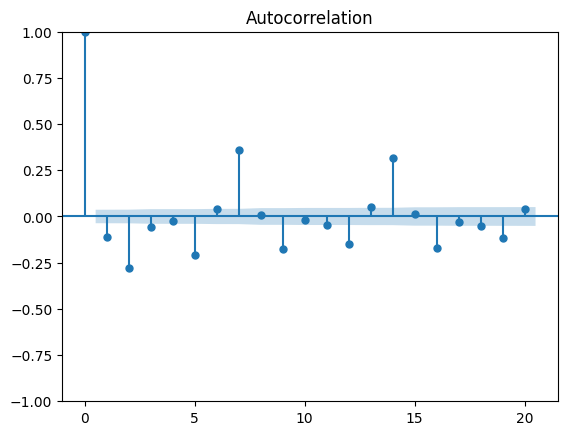

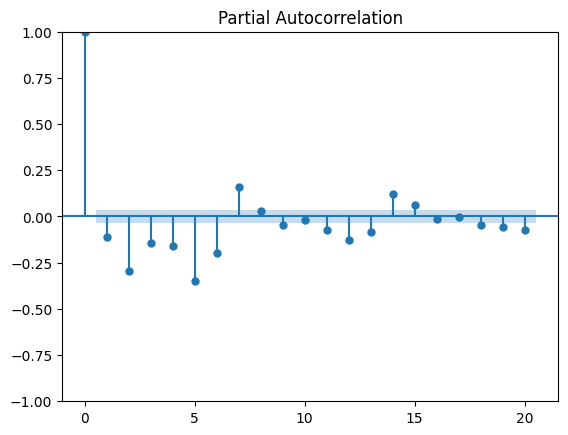

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.262622e+01
p-value                        1.539584e-23
#Lags Used                     2.800000e+01
Number of Observations Used    2.854000e+03
Critical Value (1%)           -3.432643e+00
Critical Value (5%)           -2.862553e+00
Critical Value (10%)          -2.567309e+00
dtype: float64


In [21]:
detrend_df = diff(history['y'], 1)
plt.plot(detrend_df)
plot_acf(detrend_df ,lags=20) 
plot_pacf(detrend_df ,lags=20) 
plt.show()
adf_test(detrend_df )

In [ ]:
seasa = diff(detrend_df, 7)
plt.plot(seasa)
plot_acf(seasa ,lags=20) 
plot_pacf(seasa ,lags=20) 
plt.show()
adf_test(seasa )

In [16]:
model = ARIMA(history.y,order=(0,1,2),seasonal_order=(2,1,2,7)).fit()
pred = model.forecast(len(test))
pred = pd.DataFrame(pred)

In [18]:
rmse = np.sqrt(skmetrics.mean_squared_error(test.y, pred))
rmse

0.43576332980562854